In [1]:
using Distributions
using LinearAlgebra
using Plots

In [3]:
include("../testfns.jl")
include("../rollout.jl")
include("../utils.jl")

generate_initial_guesses (generic function with 1 method)

In [4]:
toGB(bytes) = string(bytes / 1024 / 1024 / 1024) * "GB"
toMB(bytes) = string(bytes / 1024 / 1024) * "MB"

toMB (generic function with 1 method)

In [6]:
MC_SAMPLES = 500
NUMBER_OF_STARTS = 8
NUMBER_OF_TRIALS = 1
HORIZON = 0
BATCH_SIZE = 8

# Gaussian process hyperparameters
θ, σn2 = [1.], 1e-6
ψ = kernel_matern52(θ)
testfn = TestQuadratic1D()
lbs, ubs = testfn.bounds[:, 1], testfn.bounds[:, 2]

# Generate low discrepancy sequence
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, HORIZON + 1)
rns = randn(MC_SAMPLES, testfn.dim+1, HORIZON+1);

# Allocate initial guesses for optimizer
initial_guesses = generate_initial_guesses(NUMBER_OF_STARTS, lbs, ubs)

# Allocate all initial samples
initial_samples = randsample(NUMBER_OF_TRIALS, testfn.dim, lbs, ubs)

# Initialize the trajectory parameters
tp = TrajectoryParameters(
    initial_samples[:, 1], # Will be overriden later
    HORIZON,
    MC_SAMPLES,
    # lds_rns,
    rns,
    lbs,
    ubs,
)

# Initialize batch of points to evaluate the rollout acquisition function
batch = generate_batch(BATCH_SIZE, lbs=tp.lbs, ubs=tp.ubs)

# Initialize shared memory for solving base policy in parallel
candidate_locations = SharedMatrix{Float64}(testfn.dim, NUMBER_OF_STARTS)
candidate_values = SharedArray{Float64}(NUMBER_OF_STARTS)

trial = first(rand(1:NUMBER_OF_TRIALS, 1))
# Xinit = initial_samples[:, trial:trial]
Xinit = [-.9;; -.5;; .5;; .9;;]
yinit = testfn.f.(eachcol(Xinit))
sur = fit_surrogate(ψ, Xinit, yinit; σn2=σn2);

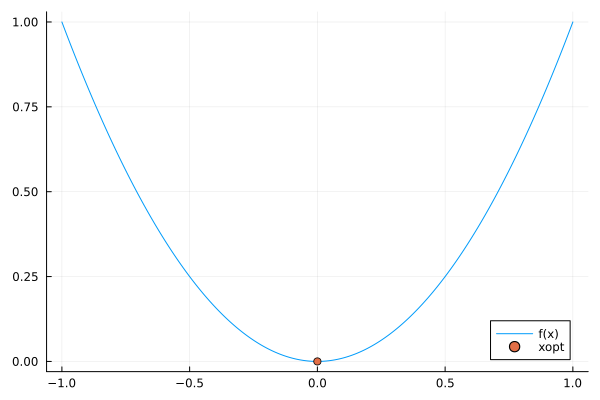

In [7]:
tplot(testfn)

In [8]:
domain = first(lbs):.01:first(ubs)
dense_evals = zeros(length(domain), 4)

for (i, x0) in enumerate(domain)
    print("|")
    tp.x0[:] = [x0]

    
    outcome = simulate_trajectory(sur, tp, initial_guesses,
        candidate_locations=candidate_locations, candidate_values=candidate_values
    )
    dense_evals[i, :] .= [outcome[1], first(outcome[2]), outcome[3], first(outcome[4])]
end

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

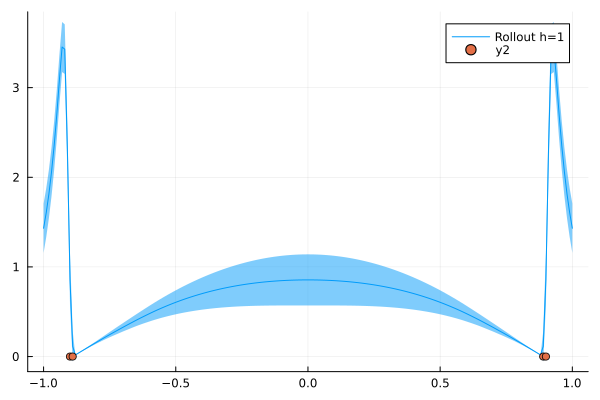

In [45]:
plot(
    domain,
    dense_evals[:, 1],
    ribbons=dense_evals[:, 3],
    label="Rollout h=$HORIZON"
)
scatter!(sur.X', zeros(length(sur.X')))

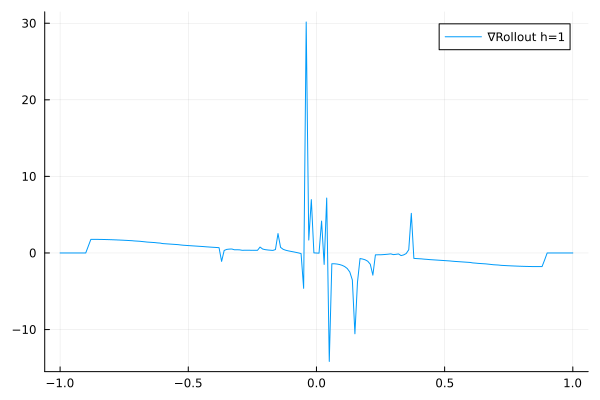

In [46]:
plot(
    domain,
    dense_evals[:, 2],
    # ribbons=dense_evals[:, 4],
    label="∇Rollout h=$HORIZON"
)

In [48]:
outcome = @timed result = simulate_trajectory(
    sur, tp, initial_guesses, candidate_locations=candidate_locations, candidate_values=candidate_values
)
toMB(outcome.bytes)

"46.741119384765625MB"

In [40]:
outcome.bytes

79160864

In [10]:
outcome = @timed rollout_outcome = rollout_solver(
    sur=sur, tp=tp, xstarts=initial_guesses, batch=batch,
    candidate_locations=candidate_locations, candidate_values=candidate_values
)
toGB(outcome.bytes)

"1.7663513692095876GB"

In [54]:
kernel = kernel_SE()

RBFfun([1.0], var"#ψ#533"{var"#k#546", Vector{Float64}}(var"#k#546"(), [1.0]), var"#Dρ_ψ#534"{var"#ψ#533"{var"#k#546", Vector{Float64}}}(var"#ψ#533"{var"#k#546", Vector{Float64}}(var"#k#546"(), [1.0])), var"#Dρρ_ψ#535"{var"#Dρ_ψ#534"{var"#ψ#533"{var"#k#546", Vector{Float64}}}}(var"#Dρ_ψ#534"{var"#ψ#533"{var"#k#546", Vector{Float64}}}(var"#ψ#533"{var"#k#546", Vector{Float64}}(var"#k#546"(), [1.0]))), var"#∇θ_ψ#536"{var"#k#546", Vector{Float64}}(var"#k#546"(), [1.0]))

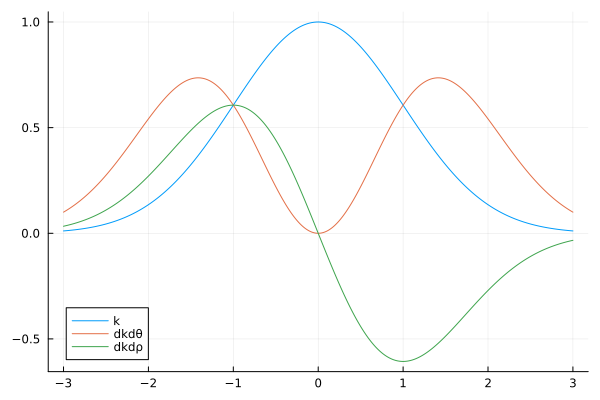

In [66]:
domain = -3.:.01:3.

plot(domain, [kernel(x) for x in domain], label="k")
plot!(domain, [first(kernel.∇θ_ψ(x)) for x in domain], label="dkdθ")
plot!(domain, [first(kernel.Dρ_ψ(x)) for x in domain], label="dkdρ")

In [62]:
outcome = @timed [first(kernel.∇θ_ψ(x)) for x in domain]

(value = [0.09998096884418076, 0.10233503155560733, 0.10473170399522903, 0.1071713745590655, 0.1096544234568653, 0.1121812222756728, 0.1147521335370547, 0.11736751024815366, 0.12002769544675572, 0.12273302174056011  …  0.12273302174056011, 0.12002769544675572, 0.11736751024815366, 0.1147521335370547, 0.1121812222756728, 0.1096544234568653, 0.1071713745590655, 0.10473170399522903, 0.10233503155560733, 0.09998096884418076], time = 0.050311, bytes = 2268587, gctime = 0.0, gcstats = Base.GC_Diff(2268587, 0, 0, 34856, 19, 0, 0, 0, 0))

In [65]:
outcome = @timed kernel.∇θ_ψ(domain[1])
toMB(outcome.bytes)

"0.0002899169921875MB"